In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.integrate import solve_ivp
from network import network
from training import trainNetwork
from dynamics import *

In [2]:
system="Robert"

In [3]:
d = 3 #dimension of the phase space

if system=="SIR":
    t_min = 0.
    t_max = 1e4
    y0 = np.array([0.3,0.5,0.2])
else:
    t_min = 0. #initial time
    t_max = 1e6 #final time
    y0 = np.array([1.,0.,0])

In [4]:
output = solve_ivp(ode,[t_min,t_max], y0, method = 'BDF', atol=1e-10, rtol=1e-10, args=(system,))
sol,time = output.y,output.t

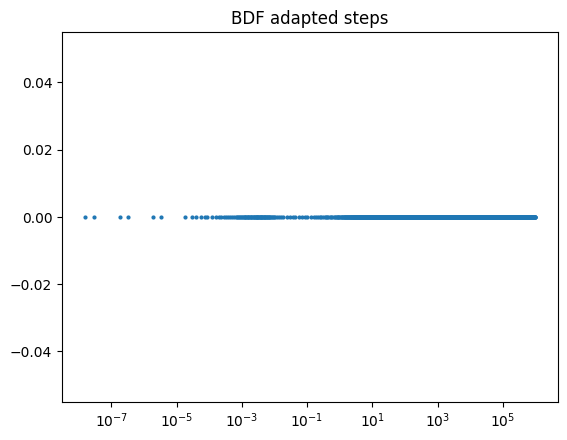

In [5]:
plt.semilogx(time,time*0,'o',markersize=2)
plt.title("BDF adapted steps")
plt.show();

In [6]:
M = len(time)
N = min(10,M)

which_idxs = lambda n, m: np.rint(
      np.linspace(1,m, min(n,m))-1).astype(int) 

coarse_time = time[which_idxs(N+1,M)]
initial_guesses = sol[:,which_idxs(N+1,M)]
dts = np.diff(coarse_time)

$$
\mathcal{D} = \{(t_j,\Phi^{t_j}(x_i))\}_{i=1,...,N}^{j=1,...,M},\,\,\{x_1,...,x_N\}\subset\Omega\subset\mathbb{R}^3,\,\,t_j\in [0,\Delta t]
$$

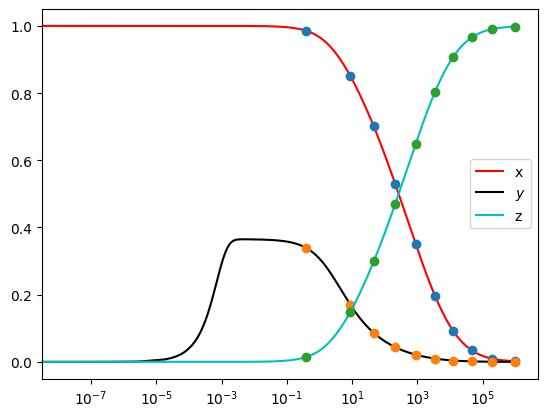

In [7]:
fact = 1e4 * (system=="Robert") + 1. * (system=="SIR")

plt.semilogx(time,sol[0],'r-',label='x')
plt.semilogx(coarse_time,initial_guesses[0],'o')
plt.semilogx(time,sol[1]*fact,'k-',label=r'$y$')
plt.semilogx(coarse_time,initial_guesses[1]*fact,'o')
plt.semilogx(time,sol[2],'c-',label='z')
plt.semilogx(coarse_time,initial_guesses[2],'o')
plt.legend()
plt.show();

In [8]:
networks = []

lr = 1e-2
wd = 1e-5
epochs = 10000

for n in range(N):
    networks.append(network(coarse_time[n],coarse_time[n+1],d))
    if n==0:
        yy0 = initial_guesses[:,n]
    if n>0:
        tt = torch.tensor([[coarse_time[n]-coarse_time[n-1]]],dtype=torch.float32)
        yy0 = networks[n-1](tt,torch.from_numpy(yy0.astype(np.float32)).unsqueeze(0)).detach().cpu().numpy()[0]
    print(f"\n\n The considered time interval now is [{coarse_time[n]},{coarse_time[n+1]}] \n\n")
    trainNetwork(yy0,coarse_time[n],coarse_time[n+1],networks[n],d,lr,wd,epochs,system,is_pinn=False,is_reg=True)



 The considered time interval now is [0.0,0.37661506013026935] 


Epoch 100, Loss 0.0001084366231225431
Epoch 200, Loss 0.00017799681518226862
Epoch 300, Loss 0.00019015940779354423
Epoch 400, Loss 6.414694507839158e-05
Epoch 500, Loss 0.00016787518688943237
Epoch 600, Loss 0.00010762162128230557
Epoch 700, Loss 8.953297947300598e-05
Epoch 800, Loss 6.464375474024564e-05
Epoch 900, Loss 7.122985698515549e-05
Epoch 1000, Loss 3.259168079239316e-05
Epoch 1100, Loss 0.00013528885028790683
Epoch 1200, Loss 0.00010414791177026927
Epoch 1300, Loss 8.65359979798086e-05
Epoch 1400, Loss 7.440030458383262e-05
Epoch 1500, Loss 0.00011256683501414955
Epoch 1600, Loss 0.00015603196516167372
Epoch 1700, Loss 0.0001080979491234757
Epoch 1800, Loss 6.922071770532057e-05
Epoch 1900, Loss 9.292311005992815e-05
Epoch 2000, Loss 3.059034497709945e-05
Epoch 2100, Loss 6.680061051156372e-05
Epoch 2200, Loss 5.468619929160923e-05
Epoch 2300, Loss 0.00012022139708278701
Epoch 2400, Loss 3.34385440510232e-0

- Iterate 0 : No data and the network should provide the initial guesses for the coarse grid (PINN)
- Iterate 1, 2,... : Combine the two losses where the regression part is based on the evaluations of
the fine integrator at the previous iterates.

In [11]:
coarse_preds = np.zeros((d,N+1))
coarse_preds[:,0] = initial_guesses[:,0]
for n in range(N):
    tt = torch.tensor([[dts[n]]],dtype=torch.float32)
    #yy = torch.from_numpy(initial_guesses[:,n].astype(np.float32)).unsqueeze(0)
    
    if n==0:
        yy = torch.from_numpy(initial_guesses[:,n:n+1].astype(np.float32)).T
    if n>0:
        dt = torch.tensor([[dts[n-1]]],dtype=torch.float32)
        yy = networks[n-1](dt,yy)
    coarse_preds[:,n+1] = networks[n](tt,yy)[0].detach().cpu().numpy()

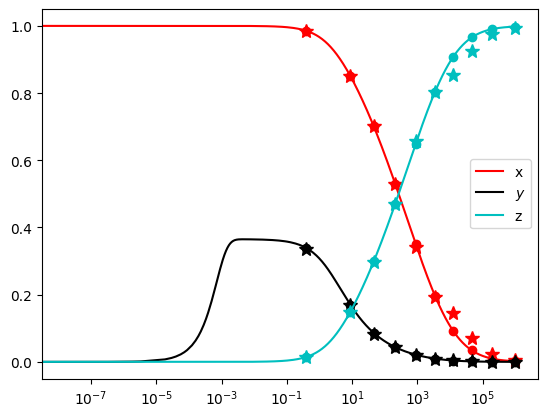

In [12]:
plt.semilogx(time,sol[0],'r-',label='x')
plt.semilogx(coarse_time,initial_guesses[0],'ro')
plt.semilogx(coarse_time,coarse_preds[0],'r*',markersize=10)
plt.semilogx(time,sol[1]*fact,'k-',label=r'$y$')
plt.semilogx(coarse_time,initial_guesses[1]*fact,'ko')
plt.semilogx(coarse_time,coarse_preds[1]*fact,'k*',markersize=10)
plt.semilogx(time,sol[2],'c-',label='z')
plt.semilogx(coarse_time,initial_guesses[2],'co')
plt.semilogx(coarse_time,coarse_preds[2],'c*',markersize=10)
plt.legend()
plt.show();